# <a id='toc1_'></a>[ITEC '24 - CS2 Analysis](#toc0_)
*By: Dario Slaifstein, PhD Candidate*
<br> Group: DCES
<br> Project: **FLEXINet**
<br> Result: 6

Source control
- Branch: `main`
- version: `0.1`
- Date: 29/11/2024

**Table of contents**<a id='toc0_'></a>    
- [ITEC '24 - CS2 Analysis](#toc1_)    
- [CS - RFO of FLEXINet](#toc2_)    
- [Capex sensitivity analysis](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
# Import all the necessary packages
# using LinearAlgebra, Distributions, Statistics, Parameters, Random, 
using EMSmodule, Random
using InfiniteOpt, KNITRO
using JSON3, MAT, StatsBase, CSV, DataFrames, Revise
using LaTeXStrings, Printf, Makie, GLMakie, CairoMakie, ColorSchemes, Distributions, Interpolations
includet("../fns/EMSrfofns.jl")
includet("../fns/build_data.jl")
Random.seed!(1234);

In [2]:
function trim_res!(results::Dict)
    # cut all the variables to the same length
    for key in keys(results)
        if length(results[key]) == 2*24*4
            results[key] = results[key][1:24*4];
        end
    end
end

trim_res! (generic function with 1 method)

# <a id='toc2_'></a>[CS - RFO of FLEXINet](#toc0_)

To account for the different availability trajectories $\gamma_{i,n_{EV},t}$ all samples are integrated into a Random Field Optimization.

The formulation is:



To better decide what to do under the presence of the uncertainty of the EV arrival time, we will use the Random Field Optimization (RFO) model. This model will help us to decide the best time to charge the EVs, since we are incorporating our uncertainty model into the constraints and objectives of the optimization problem.

Thus we change our policy from a deterministic $X^{D-DLA}(S_{a,t})$ to a stochastic one $X^{S-DLA}(S_{a,t})$. Our deterministic policy was:

\begin{equation}
    X^{D-DLA}_t(S_{a,t})= \arg \min_{P_{a,t}, ..., P_{a,t+H}}  \tilde{C}_{\textrm{grid}}+\tilde{p}_{\textrm{SoCDep}}+\tilde{p}_{\textrm{TESS}}
\end{equation}

\begin{equation}
    H x \leq 0, \forall \omega \in \Omega_{arr}
\end{equation}

\begin{equation}
    X^{S-DLA}_t(S_{a,t})= \arg \min_{P_{a,t}, ..., P_{a,t+H}}  \mathbb{E}(\tilde{C}_{\textrm{grid}}+\tilde{p}_{\textrm{SoCDep}}+\tilde{p}_{\textrm{TESS}})+Q_{\textrm{BESS}}
\end{equation}

To model Random Field Optimization (RFO) using `InfiniteOpt.jl`:

$$ \begin{aligned}
\min_{Q_{BESS}}\quad \mathbb{E}_{t_a \in \mathcal{T}}[\mathcal{C}_{i}] + c_{BESS} . Q_{BESS}\\
\text{Subject to}\\
 & \underline{P}_g \leq Pg_{i,t} \leq \overline{P}_g, \quad\forall t \in \mathcal{D}_t \quad \forall i \in [1,N_s]\\
 & 0.01 \leq Q_{BESS} \leq 50\\
 & -Q_{BESS}C_{rate} \leq P_{BESS,i,t} \leq Q_{BESS}C_{rate}, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s]\\
 & 0.2 Q_{BESS} \leq SoC_{BESS,i}(t) \leq 0.95 Q_{BESS}, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s]\\
 
 & \underline{P}_{n_{EV}} \leq P_{n_{EV},i,t} \leq \overline{P}_{n_{EV}}, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s]\\
 & \underline{P}_{n_{EV}} \leq P_{Tot,n_{EV},i,t} \leq \overline{P}_{n_{EV}}, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s]\\
 & 11.13 \leq SoC_{n_{EV},i,t} \leq 52.87, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s]\\
 & \underline{P}_g \leq P_{g,i,t} \leq \overline{P}_g, \quad\forall t \in \mathcal{D}_t\\
 & 0 \leq P_{HP,i,t}^e \leq \overline{P}_{HP}, \quad\forall t \in \mathcal{D}_t\\
 & \underline{P}_{TESS} \leq P_{TESS,i,t} \leq \overline{P}_{TESS}, \quad\forall t \in \mathcal{D}_t\\
 & 0.1 \leq SoC_{TESS,i,t} \leq 0.95, \quad\forall t \in \mathcal{D}_t\\
 
 & \frac{\partial}{\partial t}\left[SoC_{BESS,i,t}\right] + P_{BESS,i,t} = 0, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s]\\
 & \frac{\partial}{\partial t}\left[SoC_{n_{EV},i,t}\right] + P_{Tot,n_{EV},i,t} = 0, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s]\\
  & \frac{\partial}{\partial t}\left[SoC_{TESS,i,t}\right] + \frac{\eta_{TESS}}{Q_{TESS}}  P_{TESS,i,t} = 0, \quad\forall t \in \mathcal{D}_t\\

 & γ_{n_{EV},i,t} P_{n_{EV},i,t} + (1-γ_{n_{EV},i,t}) P_{drive,n_{EV},i} - P_{Tot,n_{EV},i,t} = 0, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s]\\ 
 & \sum_{n_{EV}=1}^{N_{EV}} γ_{f,n_{EV},i,t}.P_{n_{EV},i,t} + P_{PV,t} + P_{BESS,i,t} + P_{g,i,t} - P_{l,t}^e - P_{HP,i,t}^e = 0, \quad\forall t \in \mathcal{D}_t, \forall i \in [1,N_s] \\
& P_{st,t} + COP. P_{HP,i,t}^e + P_{TESS,i,t} - P_{l,t}^{th} = 0, \quad\forall t \in \mathcal{D}_t\\

 & SoC_{BESS,i}(0.25) = 0.5 Q_{BESS} \quad \forall i \in [1,N_s]\\
 & SoC_{n_{EV}=1,i}(0.25) = 33.3899 \quad \forall i \in [1,N_s]\\
 & SoC_{n_{EV}=2,i}(0.25) = 44.5199 \quad \forall i \in [1,N_s]\\
 & SoC_{TESS,i}(0.25) = 0.4 \quad \forall i \in [1,N_s]\\
 
\end{aligned} $$

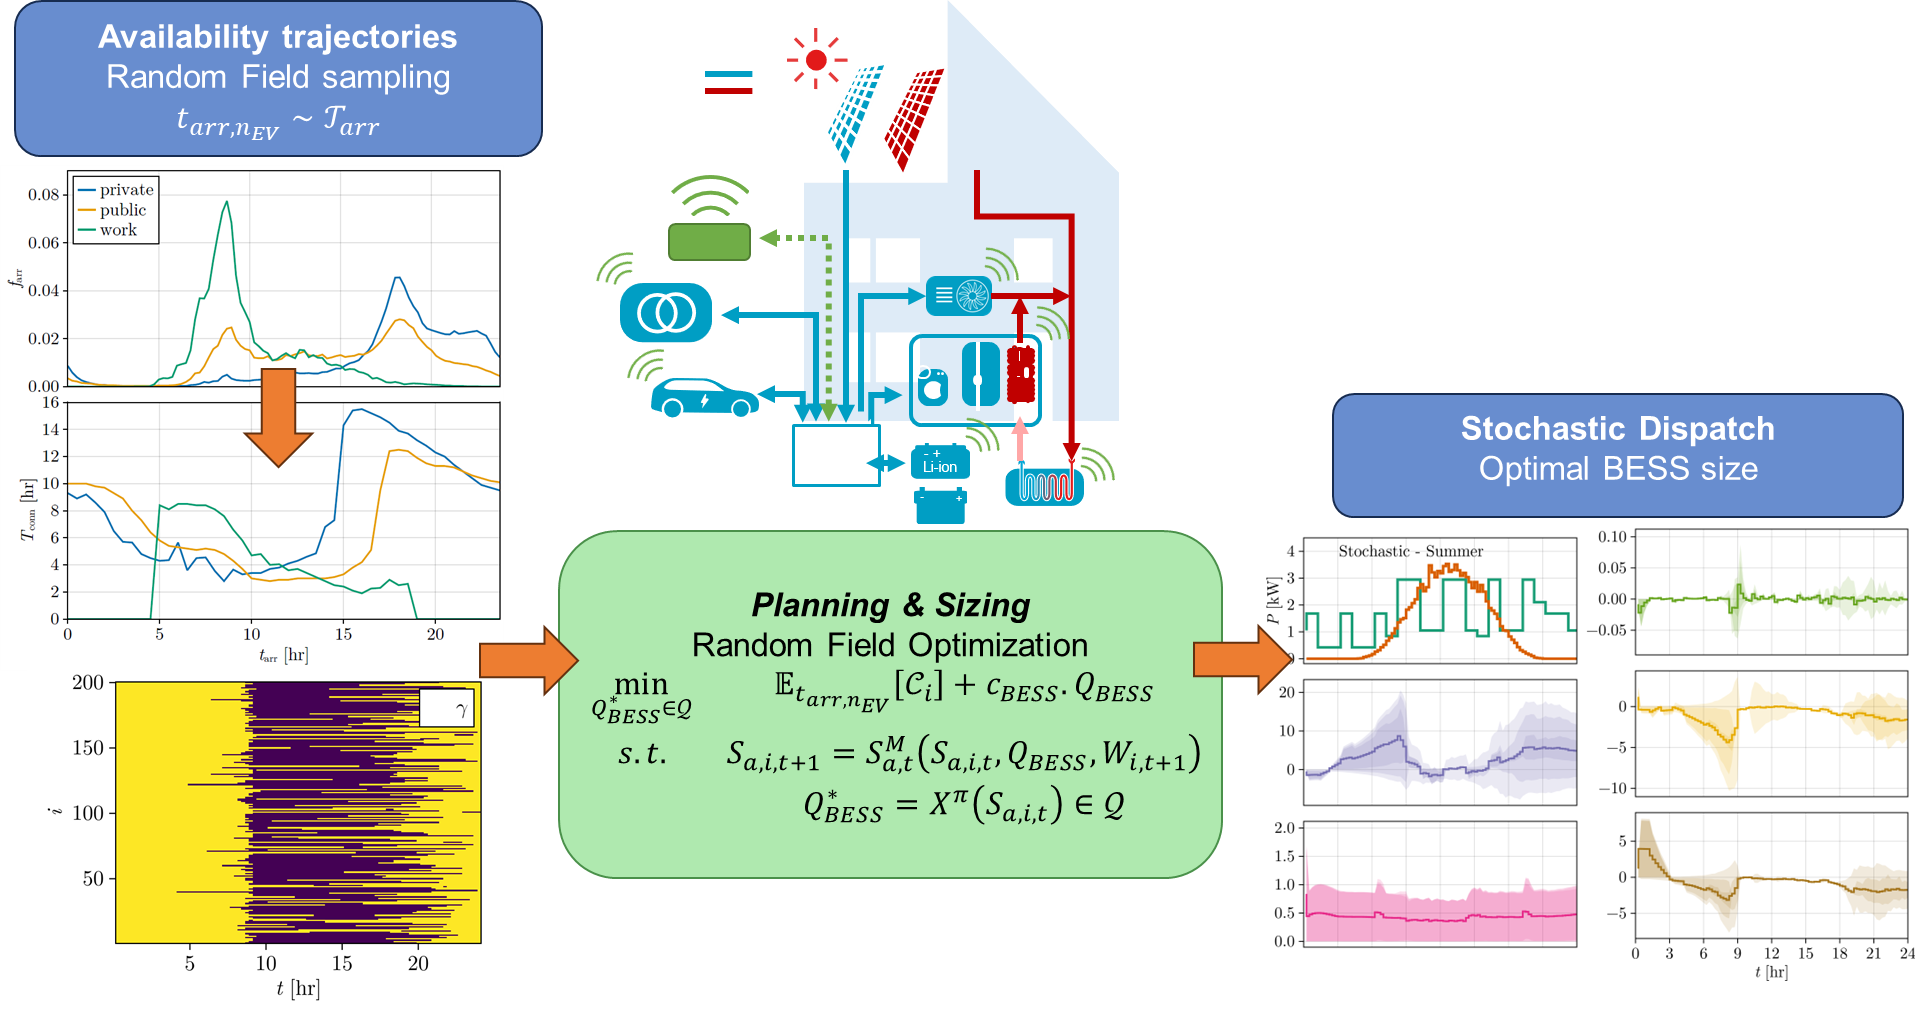

# <a id='toc3_'></a>[Capex sensitivity analysis](#toc0_)
We now analyze the sensitivity of the optimal BESS capacity $Q_{\textrm{BESS}}$ with respect to the investment cost of the kWh $c_{\textrm{BESS}}$.

In [ ]:
folder = "../data/output/RFO/";
sens_df = Dict(:winter => DataFrame(), :summer => DataFrame());
sens_df[:winter] = CSV.read(folder * "sensitivity_analysis_winter_RFO_s500.csv", DataFrame)
sens_df[:summer] = CSV.read(folder * "sensitivity_analysis_summer_RFO_s500.csv", DataFrame)
[sens_df[season] = sens_df[season][1:30,:] for season ∈ keys(sens_df)]

2-element Vector{DataFrame}:
 30×3 DataFrame
 Row │ CAPEX    Qbess       cost      
     │ Float64  Float64     Float64   
─────┼────────────────────────────────
   1 │    0.01  50.0        -5.6724
   2 │    0.02  50.0        -5.1724
   3 │    0.03  50.0        -4.6724
   4 │    0.04  50.0        -4.1724
   5 │    0.05  50.0        -3.6724
   6 │    0.06  50.0        -3.1724
   7 │    0.07  50.0        -2.6724
   8 │    0.08  50.0        -2.1724
  ⋮  │    ⋮         ⋮           ⋮
  24 │    0.24   0.0245199   2.80449
  25 │    0.25   0.0100001   2.80373
  26 │    0.26   0.0159035   2.80449
  27 │    0.27   0.0135227   2.80449
  28 │    0.28   0.0117608   2.80449
  29 │    0.29   0.0104049   2.80449
  30 │    0.3    0.0100004   2.80456
                       15 rows omitted
 30×3 DataFrame
 Row │ CAPEX    Qbess       cost    
     │ Float64  Float64     Float64 
─────┼──────────────────────────────
   1 │    0.01  50.0        5.0288
   2 │    0.02  50.0        5.5288
   3 │    0.03  50.0 

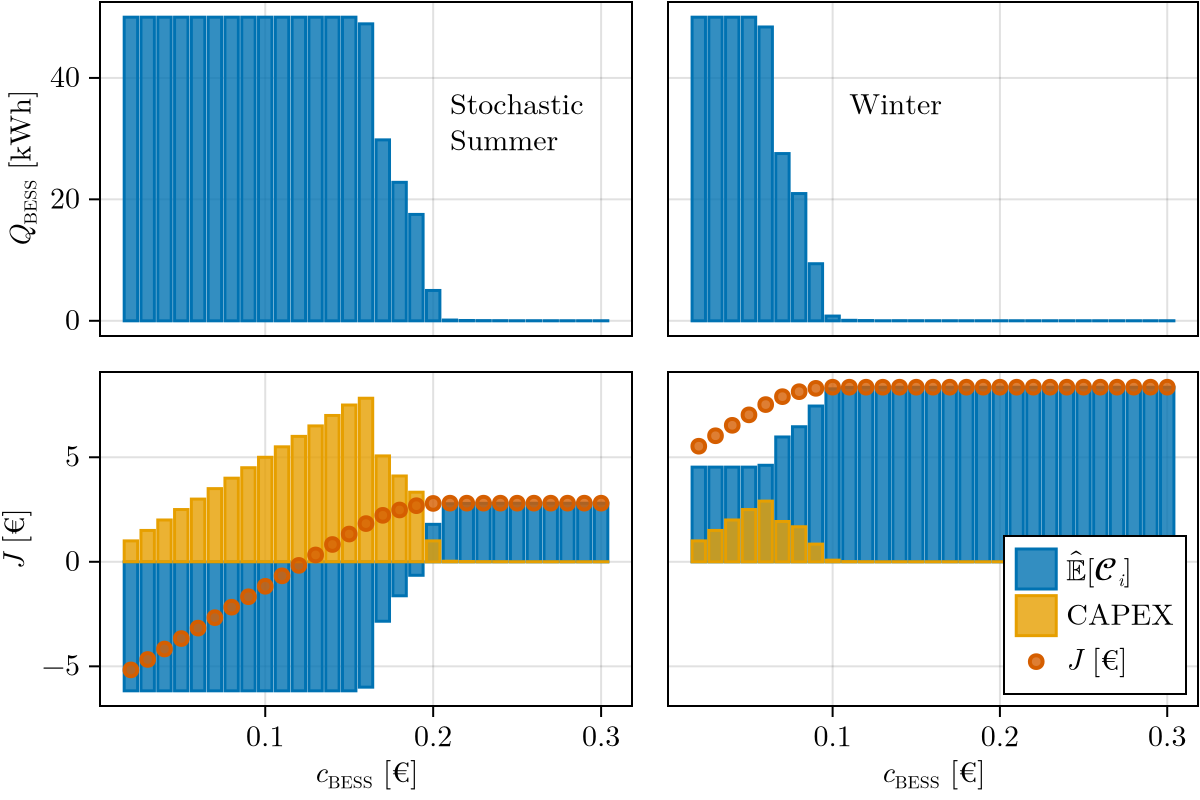

In [ ]:
CairoMakie.activate!()
set_theme!(theme_latexfonts(), fontsize = 15,
        figure_padding = (1, 1., 5., 1.), # left, right, bottom, top
        )
f = Figure(size = (600, 400));
axes = Matrix{Axis}(undef, 2, 2)
for (j, season) ∈ enumerate(keys(sens_df))
    ax1 = Axis(f[1,j],
        xlabel = L"$c_{\textrm{BESS}}$\ [€]",
        ylabel = L"$Q_{\textrm{BESS}}$ [kWh]",
        # limits = (0., 0.3, nothing, nothing),
        )
    ax2 = Axis(f[2,j],
        xlabel = L"$c_{\textrm{BESS}}$\ [€]",
        ylabel = L"$J$ [€]",
        # limits = (0., 0.3, nothing, nothing),
        )
    colors = Makie.wong_colors()
    barplot!(ax1, sens_df[season].CAPEX[2:end], sens_df[season].Qbess[2:end], 
        color=(colors[1], 0.8), strokecolor = colors[1], strokewidth = 1.5, label = L"$Q_{\textrm{BESS}}$")
    barplot!(ax2, sens_df[season].CAPEX[2:end], sens_df[season].cost[2:end] .-
             sens_df[season].CAPEX[2:end] .* sens_df[season].Qbess[2:end], 
             color=(colors[1], 0.8), strokecolor = colors[1], strokewidth = 1.5,
             label = L"\hat{\mathbb{E}}[\mathcal{C}_i]")
    barplot!(ax2, sens_df[season].CAPEX[2:end], sens_df[season].CAPEX[2:end] .* sens_df[season].Qbess[2:end],
        color=(colors[2], 0.8), strokecolor = colors[2], strokewidth = 1.5,label = "CAPEX")
    scatter!(ax2, sens_df[season].CAPEX[2:end], sens_df[season].cost[2:end], label = L"$J$ [€]",
         color = (colors[6],0.80), strokewidth = 2, strokecolor = colors[6])
    # barplot!(ax2, sens_df.CAPEX[2:end], sens_df.cost[2:end] .- sens_df.CAPEX[2:end] .* sens_df.Qbess[2:end], label = "OPEX")
    axes[1,j] = ax1; axes[2,j] = ax2;
end
axislegend(axes[2,2], position=:rb, fontsize=10, merge = true)
[linkyaxes!(axes[i,1], axes[i,2]) for i ∈ 1:2]
hidexdecorations!.(axes[1,:], grid = false);
hideydecorations!.(axes[:,2], grid = false);
text!(axes[1,1], .21, 38., text= "Stochastic\nSummer", justification = :left, align = (:left, :top))
text!(axes[1,2], .11, 38., text= "Winter", align = (:left, :top))
# save("../images/stochastic/SensAnalysis_CS2.pdf", f)
f